# Idea: Compare overall process times of instances

-> Sum the process time for a serial number and compare the times on the time axis

## 1. Group SerialNumbers based on their Stations

Idea: Items (Serial Numbers) can be compared by selecting their stations. All items with the same station order form a Group.

In [2]:
import pandas as pd

# Load the data from JSON
data = pd.read_json("processtimes.json")

# Create a dictionary to store unique stations per serial number as a single string
stations_per_item = {}

for serial_number in data["SerialNumber"].unique():
    # Get unique stations for the current serial number and join them into a single string
    unique_stations = ", ".join(data[data["SerialNumber"] == serial_number]["StationName"].unique())
    stations_per_item[serial_number] = unique_stations

# Convert the dictionary to a DataFrame for easy comparison
stations_per_item_df = pd.DataFrame(list(stations_per_item.items()), columns=["SerialNumber", "Stations"])

# Identify unique station groups and assign a group ID for each unique set of stations
stations_per_item_df["Group_ID"] = stations_per_item_df.groupby("Stations").ngroup()

# Sort the DataFrame by Group_ID for easier viewing
stations_per_item_df = stations_per_item_df.sort_values(by="Group_ID").reset_index(drop=True)

# Display the DataFrame with groups
stations_per_item_df


,SerialNumber,Stations,Group_ID
0,1,"StationName1, StationName23, StationName39, St...",0
1,14,"StationName1, StationName23, StationName39, St...",0
2,11224,StationName10,1
3,20878,"StationName10, StationName38, StationName61",2
4,25890,"StationName10, StationName38, StationName61",2
...,...,...,...
26360,15187,StationName97,842
26361,10235,StationName97,842
26362,16470,StationName97,842
26363,538,"StationName99, StationName133",843


# 2. Enrich Groups with Timestamp and compute overall process time

To be able to filter the occurences by time, we add the first check in time from each serial number -> This is the time where an item entered the production line

In the next step, we calculcate the total process time for each item.

In [3]:
first_occurrences = data.loc[data.groupby("SerialNumber")["TimeStamp"].idxmin()]

first_occurrences = first_occurrences[['SerialNumber', 'TimeStamp']]

first_occurrences

,SerialNumber,TimeStamp
1,1,2024-10-23 17:19:37.079000+02:00
292,2,2024-10-23 17:19:37.123000+02:00
192,3,2024-10-23 17:19:37.125000+02:00
161,4,2024-10-23 17:19:37.125000+02:00
282,5,2024-10-23 17:19:37.120000+02:00
...,...,...
114359,26494,2024-10-23 18:22:27.739000+02:00
114339,26495,2024-10-23 18:22:28.458000+02:00
114360,26503,2024-10-23 18:22:27.739000+02:00
114384,26506,2024-10-23 18:22:30.681000+02:00


In [4]:
processtime_per_station = data.groupby("SerialNumber")["Value"].sum()

stations_per_item_df = pd.merge(stations_per_item_df, processtime_per_station, on="SerialNumber", how="inner")

stations_per_item_df = stations_per_item_df.rename(columns={"Value":"ProcessTime"})
stations_per_item_df = pd.merge(stations_per_item_df, first_occurrences, on='SerialNumber', how='inner')

stations_per_item_df = stations_per_item_df.rename(columns={'TimeStamp':'FirstCheckIn'})

stations_per_item_df

,SerialNumber,Stations,Group_ID,ProcessTime,FirstCheckIn
0,1,"StationName1, StationName23, StationName39, St...",0,72.994,2024-10-23 17:19:37.079000+02:00
1,14,"StationName1, StationName23, StationName39, St...",0,74.360,2024-10-23 17:19:37.079000+02:00
2,11224,StationName10,1,3.520,2024-10-23 17:43:53.901000+02:00
3,20878,"StationName10, StationName38, StationName61",2,10.758,2024-10-23 18:08:10.132000+02:00
4,25890,"StationName10, StationName38, StationName61",2,10.610,2024-10-23 18:20:47.373000+02:00
...,...,...,...,...,...
26360,15187,StationName97,842,0.043,2024-10-23 17:53:25.482000+02:00
26361,10235,StationName97,842,0.062,2024-10-23 17:41:52.525000+02:00
26362,16470,StationName97,842,0.114,2024-10-23 17:57:15.551000+02:00
26363,538,"StationName99, StationName133",843,5.712,2024-10-23 17:19:52.534000+02:00


## 3. Compute statistical variables for each Group

In [5]:
# Ensure ProcessTime is numeric and valid
stations_per_item_df["ProcessTime"] = pd.to_numeric(stations_per_item_df["ProcessTime"], errors="coerce")

# Calculate the 25th percentile for each Group_ID
q25_values = (
    stations_per_item_df.groupby("Group_ID")["ProcessTime"]
    .quantile(0.25)
    .reset_index()
    .rename(columns={"ProcessTime": "Q25"})
)

q75_values = (
    stations_per_item_df.groupby("Group_ID")["ProcessTime"]
    .quantile(0.75)
    .reset_index()
    .rename(columns={"ProcessTime": "Q75"})
)

q90_values = (
    stations_per_item_df.groupby("Group_ID")["ProcessTime"]
    .quantile(0.90)
    .reset_index()
    .rename(columns={"ProcessTime": "Q90"})
)

median_values = (
    stations_per_item_df.groupby("Group_ID")["ProcessTime"]
    .median()
    .reset_index()
    .rename(columns={"ProcessTime": "Median"})
)

# Merge statistical values into dataset
stations_per_item_df = pd.merge(stations_per_item_df, q25_values, on="Group_ID", how="left")
stations_per_item_df = pd.merge(stations_per_item_df, q90_values, on="Group_ID", how="left")
stations_per_item_df = pd.merge(stations_per_item_df, q75_values, on="Group_ID", how="left")
stations_per_item_df = pd.merge(stations_per_item_df, median_values, on="Group_ID", how="left")


## 4. Combine items in a group into TimeGroups based on their CheckIn

This allows to see changes in charges of items

In [6]:
stations_per_item_df_subgrouped = stations_per_item_df.sort_values(by=["Group_ID", "FirstCheckIn"])

stations_per_item_df_subgrouped["TimeGroup"] = stations_per_item_df_subgrouped.groupby("Group_ID").cumcount() // 10 + 1

stations_per_item_df_subgrouped

,SerialNumber,Stations,Group_ID,ProcessTime,FirstCheckIn,Q25,Q90,Q75,Median,TimeGroup
0,1,"StationName1, StationName23, StationName39, St...",0,72.994,2024-10-23 17:19:37.079000+02:00,73.33550,74.2234,74.01850,73.6770,1
1,14,"StationName1, StationName23, StationName39, St...",0,74.360,2024-10-23 17:19:37.079000+02:00,73.33550,74.2234,74.01850,73.6770,1
2,11224,StationName10,1,3.520,2024-10-23 17:43:53.901000+02:00,3.52000,3.5200,3.52000,3.5200,1
3,20878,"StationName10, StationName38, StationName61",2,10.758,2024-10-23 18:08:10.132000+02:00,10.64700,10.7432,10.72100,10.6840,1
4,25890,"StationName10, StationName38, StationName61",2,10.610,2024-10-23 18:20:47.373000+02:00,10.64700,10.7432,10.72100,10.6840,1
...,...,...,...,...,...,...,...,...,...,...
26337,21163,StationName97,842,0.044,2024-10-23 18:08:51.276000+02:00,0.04300,0.0890,0.06000,0.0480,9
26332,22306,StationName97,842,0.041,2024-10-23 18:11:25.209000+02:00,0.04300,0.0890,0.06000,0.0480,9
26359,25691,StationName97,842,0.048,2024-10-23 18:20:22.730000+02:00,0.04300,0.0890,0.06000,0.0480,9
26363,538,"StationName99, StationName133",843,5.712,2024-10-23 17:19:52.534000+02:00,5.71275,5.7147,5.71425,5.7135,1


## 5. Calculate Exponentially Weighted Moving Average for each TimeGroup in a Group

In [ ]:
import numpy as np
# Calculate Drift Indicator for each Group_ID and TimeGroup
alpha = 0.3  # EWMA smoothing factor
drift_threshold = 0.5  # Threshold for Drift Indicator

# Group by Group_ID and TimeGroup
grouped = stations_per_item_df_subgrouped.groupby(["Group_ID", "TimeGroup"])

# Apply calculations within each group
results = []
for (group_id, time_group), group_data in grouped:
    group_data = group_data.copy()
    group_data["EWMA"] = group_data["ProcessTime"].ewm(alpha=alpha, adjust=False).mean()
    group_data["DriftIndicator"] = group_data["ProcessTime"] - group_data["EWMA"]
    group_data["Alert"] = np.abs(group_data["DriftIndicator"]) > drift_threshold
    results.append(group_data)

# Combine processed groups into a single DataFrame
processed_df = pd.concat(results).reset_index(drop=True)

processed_df

,SerialNumber,Stations,Group_ID,ProcessTime,FirstCheckIn,Q25,Q90,Q75,Median,TimeGroup,EWMA,DriftIndicator,Alert
0,1,"StationName1, StationName23, StationName39, St...",0,72.994,2024-10-23 17:19:37.079000+02:00,73.33550,74.2234,74.01850,73.6770,1,72.994000,0.000000,False
1,14,"StationName1, StationName23, StationName39, St...",0,74.360,2024-10-23 17:19:37.079000+02:00,73.33550,74.2234,74.01850,73.6770,1,73.403800,0.956200,True
2,11224,StationName10,1,3.520,2024-10-23 17:43:53.901000+02:00,3.52000,3.5200,3.52000,3.5200,1,3.520000,0.000000,False
3,20878,"StationName10, StationName38, StationName61",2,10.758,2024-10-23 18:08:10.132000+02:00,10.64700,10.7432,10.72100,10.6840,1,10.758000,0.000000,False
4,25890,"StationName10, StationName38, StationName61",2,10.610,2024-10-23 18:20:47.373000+02:00,10.64700,10.7432,10.72100,10.6840,1,10.713600,-0.103600,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26360,21163,StationName97,842,0.044,2024-10-23 18:08:51.276000+02:00,0.04300,0.0890,0.06000,0.0480,9,0.047990,-0.003990,False
26361,22306,StationName97,842,0.041,2024-10-23 18:11:25.209000+02:00,0.04300,0.0890,0.06000,0.0480,9,0.045893,-0.004893,False
26362,25691,StationName97,842,0.048,2024-10-23 18:20:22.730000+02:00,0.04300,0.0890,0.06000,0.0480,9,0.046525,0.001475,False
26363,538,"StationName99, StationName133",843,5.712,2024-10-23 17:19:52.534000+02:00,5.71275,5.7147,5.71425,5.7135,1,5.712000,0.000000,False


## 6. Test using Group 817

In [ ]:
group817 = processed_df[processed_df['Group_ID'] == 817]

group817_unique_timestamps = group817.drop_duplicates(subset=["FirstCheckIn"])

group817_unique_timestamps

,SerialNumber,Stations,Group_ID,ProcessTime,FirstCheckIn,Q25,Q90,Q75,Median,TimeGroup,EWMA,DriftIndicator,Alert
23172,303,"StationName87, StationName76",817,10.276,2024-10-23 17:19:48.093000+02:00,13.0,14.6463,14.097,13.537,1,10.276000,0.000000,False
23180,634,"StationName87, StationName76",817,11.545,2024-10-23 17:20:01.854000+02:00,13.0,14.6463,14.097,13.537,1,9.957292,1.587708,True
23188,934,"StationName87, StationName76",817,13.238,2024-10-23 17:20:18.799000+02:00,13.0,14.6463,14.097,13.537,2,14.053743,-0.815743,True
23196,1158,"StationName87, StationName76",817,13.920,2024-10-23 17:20:34.025000+02:00,13.0,14.6463,14.097,13.537,3,12.915541,1.004459,True
23204,1336,"StationName87, StationName76",817,12.506,2024-10-23 17:20:52.444000+02:00,13.0,14.6463,14.097,13.537,4,12.219630,0.286370,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25012,25983,"StationName87, StationName76",817,14.571,2024-10-23 18:21:02.787000+02:00,13.0,14.6463,14.097,13.537,185,14.571000,0.000000,False
25020,26054,"StationName87, StationName76",817,12.502,2024-10-23 18:21:18.995000+02:00,13.0,14.6463,14.097,13.537,185,13.245727,-0.743727,True
25028,26182,"StationName87, StationName76",817,12.599,2024-10-23 18:21:35.585000+02:00,13.0,14.6463,14.097,13.537,186,13.187235,-0.588235,True
25036,26278,"StationName87, StationName76",817,13.999,2024-10-23 18:21:50.837000+02:00,13.0,14.6463,14.097,13.537,187,13.650362,0.348638,False


In [10]:
grouped_df = (
    group817.groupby(["Group_ID", "TimeGroup"], as_index=False)
    .agg(
        AverageProcessTime=("ProcessTime", "mean"),
        FirstCheckIn=("FirstCheckIn", "first"),
        Alert=("Alert", "any"),
        Q25=("ProcessTime", lambda x: x.quantile(0.25)),
        Q50=("ProcessTime", lambda x: x.quantile(0.50)),
        Q75=("ProcessTime", lambda x: x.quantile(0.75)),
        Q90=("ProcessTime", lambda x: x.quantile(0.90)),
    )
)

grouped_df

,Group_ID,TimeGroup,AverageProcessTime,FirstCheckIn,Alert,Q25,Q50,Q75,Q90
0,817,1,10.2724,2024-10-23 17:19:48.093000+02:00,True,9.31400,9.7625,10.22325,11.8658
1,817,2,13.5581,2024-10-23 17:20:01.854000+02:00,True,12.53425,13.0450,13.84175,16.1269
2,817,3,13.4504,2024-10-23 17:20:18.799000+02:00,True,13.42500,13.8305,14.13925,14.4371
3,817,4,12.2500,2024-10-23 17:20:34.025000+02:00,True,11.61825,12.4270,13.35825,13.7092
4,817,5,11.5478,2024-10-23 17:21:09.858000+02:00,True,10.63175,11.3825,12.91125,13.8253
...,...,...,...,...,...,...,...,...,...
183,817,184,14.7508,2024-10-23 18:20:28.533000+02:00,True,13.82975,14.8915,15.73075,16.0739
184,817,185,13.5477,2024-10-23 18:21:02.787000+02:00,True,13.13175,13.5130,14.08925,14.4234
185,817,186,13.1426,2024-10-23 18:21:18.995000+02:00,True,12.84250,13.0990,13.40125,13.6387
186,817,187,13.6351,2024-10-23 18:21:35.585000+02:00,True,13.35350,13.5555,13.94575,14.3096


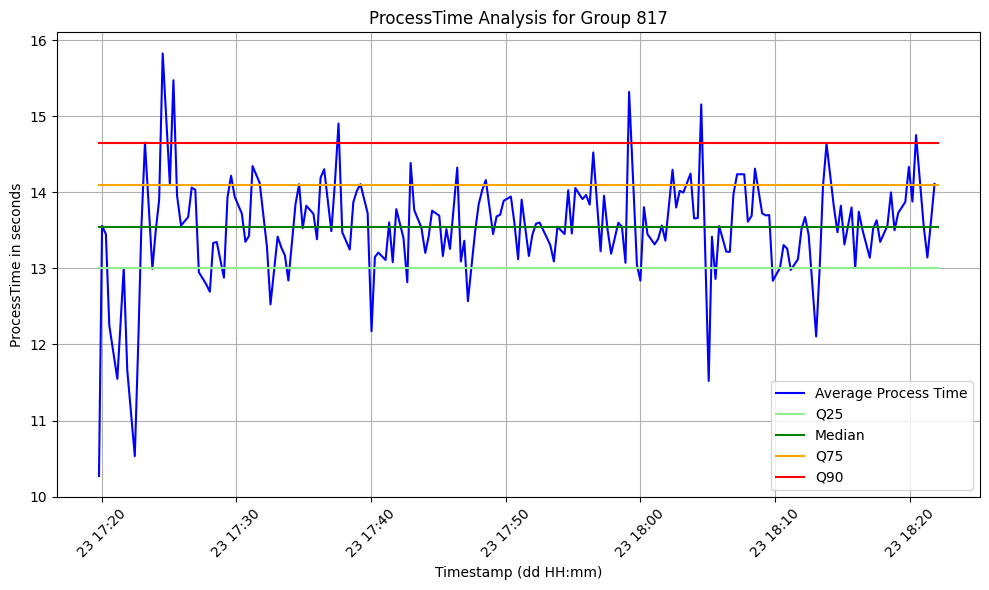

In [11]:
import matplotlib.pyplot as plt

data_serial_303 = data[data["SerialNumber"] == 634]


# Plotting the DriftIndicator values
plt.figure(figsize=(10, 6))
plt.plot(grouped_df["FirstCheckIn"], grouped_df["AverageProcessTime"], label="Average Process Time", color='b')
plt.plot(group817_unique_timestamps["FirstCheckIn"], group817_unique_timestamps["Q25"], label="Q25", color='lightgreen')
plt.plot(group817_unique_timestamps["FirstCheckIn"], group817_unique_timestamps["Median"], label="Median", color='g')
plt.plot(group817_unique_timestamps["FirstCheckIn"], group817_unique_timestamps["Q75"], label="Q75", color='orange')
plt.plot(group817_unique_timestamps["FirstCheckIn"], group817_unique_timestamps["Q90"], label="Q90", color='red')



# Formatting the plot
plt.title("ProcessTime Analysis for Group 817")
plt.xlabel("Timestamp (dd HH:mm)")
plt.ylabel("ProcessTime in seconds")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare data
group817 = processed_df[processed_df["Group_ID"] == 817]
X = np.arange(len(group817)).reshape(-1, 1)  # Sequential index as feature
y = group817["ProcessTime"]

# Fit a linear regression model
reg = LinearRegression().fit(X, y)
group817["RegressionBaseline"] = reg.predict(X)

# Calculate deviations
group817["DeviationFromBaseline"] = group817["ProcessTime"] - group817["RegressionBaseline"]

# Detect anomalies
DEVIATION_THRESHOLD = 0.5  # Define a threshold for drift
group817["IsAnomaly"] = group817["DeviationFromBaseline"] > DEVIATION_THRESHOLD


/var/folders/8z/dhxr_lc91b9788jf4ly8lf740000gn/T/ipykernel_70812/2693459692.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group817["RegressionBaseline"] = reg.predict(X)
/var/folders/8z/dhxr_lc91b9788jf4ly8lf740000gn/T/ipykernel_70812/2693459692.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group817["DeviationFromBaseline"] = group817["ProcessTime"] - group817["RegressionBaseline"]
/var/folders/8z/dhxr_lc91b9788jf4ly8lf740000gn/T/ipykernel_70812/2693459692.py:18: SettingWithCopyWarning: 
A val

In [18]:
group817.head(50)

,SerialNumber,Stations,Group_ID,ProcessTime,FirstCheckIn,Q25,Q90,Q75,Median,TimeGroup,EWMA,DriftIndicator,Alert,RegressionBaseline,DeviationFromBaseline,IsAnomaly
23172,303,"StationName87, StationName76",817,10.276,2024-10-23 17:19:48.093000+02:00,13.0,14.6463,14.097,13.537,1,10.276000,0.000000,False,13.344974,-3.068974,False
23173,302,"StationName87, StationName76",817,10.065,2024-10-23 17:19:48.093000+02:00,13.0,14.6463,14.097,13.537,1,10.212700,-0.147700,False,13.345176,-3.280176,False
23174,299,"StationName87, StationName76",817,9.868,2024-10-23 17:19:48.093000+02:00,13.0,14.6463,14.097,13.537,1,10.109290,-0.241290,False,13.345379,-3.477379,False
23175,297,"StationName87, StationName76",817,9.657,2024-10-23 17:19:48.093000+02:00,13.0,14.6463,14.097,13.537,1,9.973603,-0.316603,False,13.345581,-3.688581,False
23176,294,"StationName87, StationName76",817,9.264,2024-10-23 17:19:48.093000+02:00,13.0,14.6463,14.097,13.537,1,9.760722,-0.496722,False,13.345783,-4.081783,False
23177,296,"StationName87, StationName76",817,9.464,2024-10-23 17:19:48.093000+02:00,13.0,14.6463,14.097,13.537,1,9.671705,-0.207705,False,13.345985,-3.881985,False
23178,293,"StationName87, StationName76",817,9.021,2024-10-23 17:19:48.093000+02:00,13.0,14.6463,14.097,13.537,1,9.476494,-0.455494,False,13.346188,-4.325188,False
23179,546,"StationName87, StationName76",817,8.811,2024-10-23 17:19:48.093000+02:00,13.0,14.6463,14.097,13.537,1,9.276846,-0.465846,False,13.346390,-4.535390,False
23180,634,"StationName87, StationName76",817,11.545,2024-10-23 17:20:01.854000+02:00,13.0,14.6463,14.097,13.537,1,9.957292,1.587708,True,13.346592,-1.801592,False
23181,646,"StationName87, StationName76",817,14.753,2024-10-23 17:20:01.854000+02:00,13.0,14.6463,14.097,13.537,1,11.396004,3.356996,True,13.346795,1.406205,True


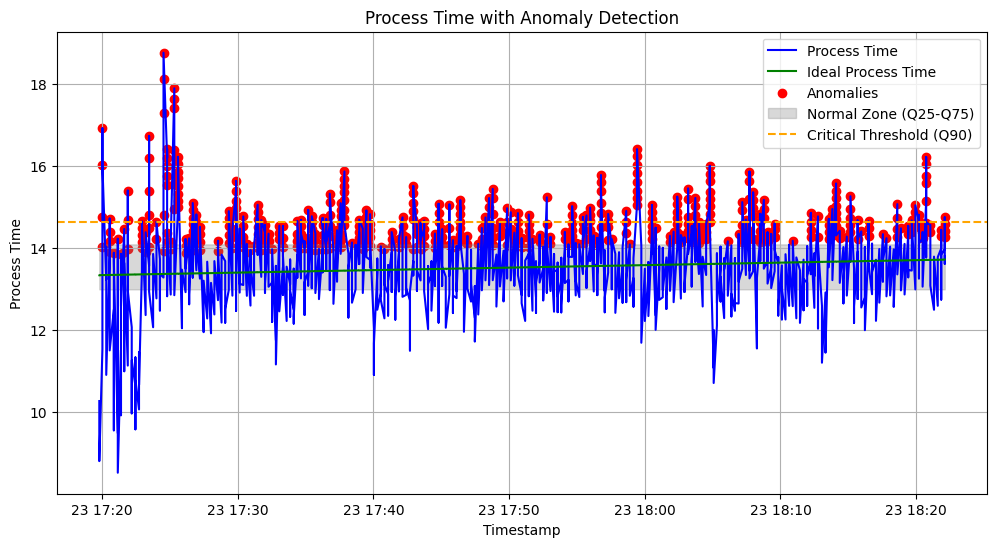

In [19]:
import matplotlib.pyplot as plt

# Plot process time and regression baseline
plt.figure(figsize=(12, 6))
plt.plot(group817["FirstCheckIn"], group817["ProcessTime"], label="Process Time", color="blue")
plt.plot(group817["FirstCheckIn"], group817["RegressionBaseline"], label="Ideal Process Time", color="green")

# Highlight anomalies
anomalies = group817[group817["IsAnomaly"]]
plt.scatter(anomalies["FirstCheckIn"], anomalies["ProcessTime"], color="red", label="Anomalies")

# Quartile zones
plt.fill_between(group817["FirstCheckIn"], group817["Q25"], group817["Q75"], color="gray", alpha=0.3, label="Normal Zone (Q25-Q75)")
plt.axhline(group817["Q90"].mean(), color="orange", linestyle="--", label="Critical Threshold (Q90)")

# Format plot
plt.title("Process Time with Anomaly Detection")
plt.xlabel("Timestamp")
plt.ylabel("Process Time")
plt.legend()
plt.grid(True)
plt.show()


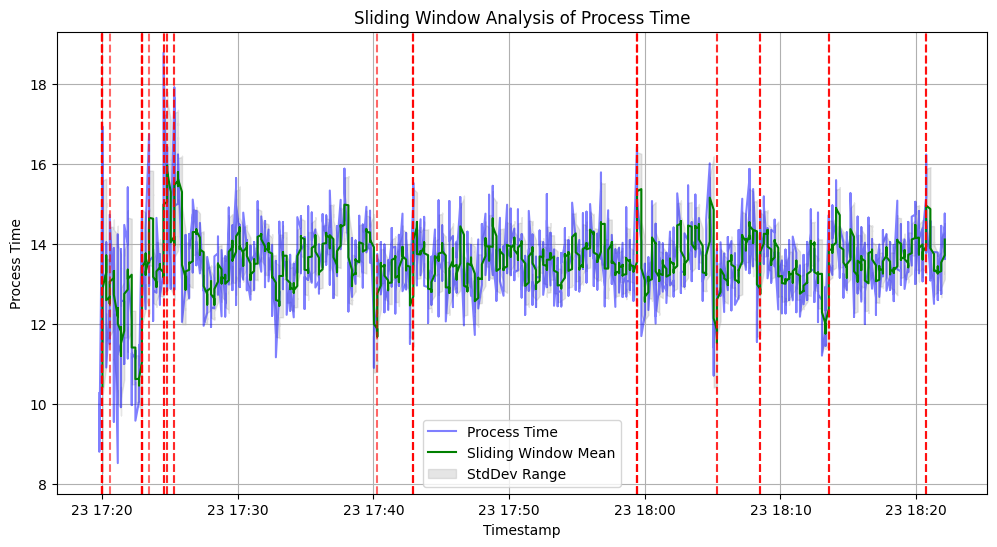

In [29]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Define sliding window size
WINDOW_SIZE = 10

# Extract the data for analysis
data817 = processed_df[processed_df["Group_ID"] == 817]
data817 = data817.sort_values("FirstCheckIn")  # Ensure data is sorted by time

# Initialize lists for sliding window results
sliding_means = []
sliding_std_devs = []
sliding_slopes = []
timestamps = []

# Perform sliding window analysis
for i in range(len(data817) - WINDOW_SIZE + 1):
    window = data817.iloc[i:i + WINDOW_SIZE]
    timestamps.append(window["FirstCheckIn"].iloc[-1])  # Take the last timestamp of the window

    # Calculate mean and standard deviation for the window
    sliding_means.append(window["ProcessTime"].mean())
    sliding_std_devs.append(window["ProcessTime"].std())

    # Fit a linear regression to the window
    X = np.arange(WINDOW_SIZE).reshape(-1, 1)
    y = window["ProcessTime"].values
    reg = LinearRegression().fit(X, y)
    sliding_slopes.append(reg.coef_[0])  # Extract the slope

# Convert results into a DataFrame for plotting
sliding_window_df = pd.DataFrame({
    "Timestamp": timestamps,
    "MeanProcessTime": sliding_means,
    "StdDevProcessTime": sliding_std_devs,
    "Slope": sliding_slopes
})

# Detect upward trends based on slope threshold
SLOPE_THRESHOLD = 0.3  # Adjust based on sensitivity
sliding_window_df["UpwardTrendDetected"] = sliding_window_df["Slope"] > SLOPE_THRESHOLD

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data817["FirstCheckIn"], data817["ProcessTime"], label="Process Time", color="blue", alpha=0.5)
plt.plot(sliding_window_df["Timestamp"], sliding_window_df["MeanProcessTime"], label="Sliding Window Mean", color="green")
plt.fill_between(
    sliding_window_df["Timestamp"],
    sliding_window_df["MeanProcessTime"] - sliding_window_df["StdDevProcessTime"],
    sliding_window_df["MeanProcessTime"] + sliding_window_df["StdDevProcessTime"],
    color="gray", alpha=0.2, label="StdDev Range"
)

# Highlight upward trends
upward_trends = sliding_window_df[sliding_window_df["UpwardTrendDetected"]]
for ts in upward_trends["Timestamp"]:
    plt.axvline(x=ts, color="red", linestyle="--", alpha=0.6)

plt.title("Sliding Window Analysis of Process Time")
plt.xlabel("Timestamp")
plt.ylabel("Process Time")
plt.legend()
plt.grid(True)
plt.show()


IndexError: index 1880 is out of bounds for axis 0 with size 1880

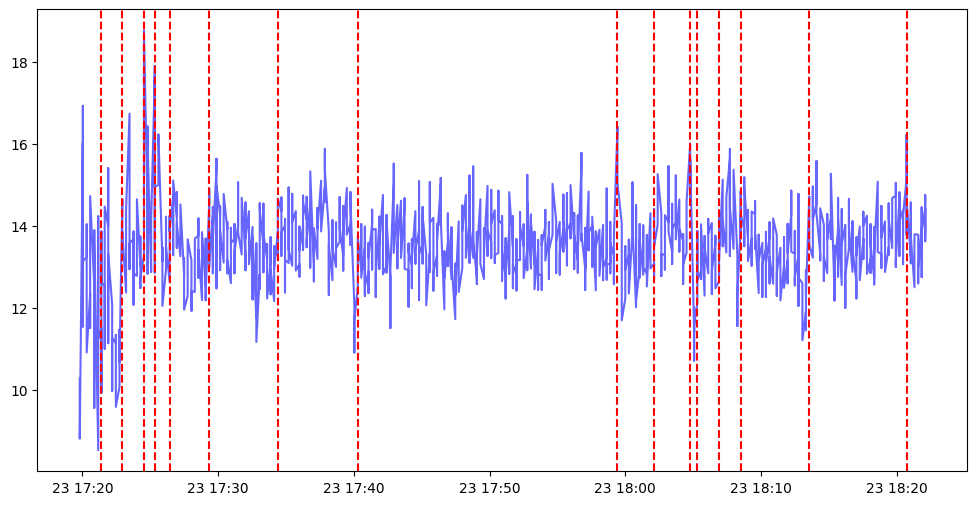

In [33]:
import ruptures as rpt
import matplotlib.pyplot as plt

# Assuming 'data817' is your DataFrame with "FirstCheckIn" and "ProcessTime"
# We need to detect the change points in the "ProcessTime" series

# Use "ProcessTime" as the input for change point detection
process_times = data817["ProcessTime"].values

# Set the model for change point detection, "l2" is for detecting mean shifts
model = "l2"  # You can also try "rbf", "normal", etc.
penalty = 10  # Adjust this penalty value as needed

# Pelt algorithm with penalty
algo = rpt.Pelt(model=model, min_size=2, jump=1).fit(process_times)

# Detect change points
change_points = algo.predict(pen=penalty)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot the original data
plt.plot(data817["FirstCheckIn"], process_times, label="Process Time", color="blue", alpha=0.6)

# Plot change points, only mark upward changes
for i in range(1, len(change_points)):  # Start from 1 to compare with the previous point
    prev_cp = change_points[i - 1]
    current_cp = change_points[i]
    
    # Check if the change is upward (i.e., ProcessTime increases after the change point)
    if process_times[current_cp] > process_times[prev_cp]:  # Upward trend
        plt.axvline(data817["FirstCheckIn"].iloc[current_cp], color="red", linestyle="--", label="Upward Change" if i == 1 else "")

plt.title("Upward Change Detection using Ruptures")
plt.xlabel("Timestamp")
plt.ylabel("Process Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


